# Deep Learning & Art: Neural Style Transfer

In this notebook, we will implement Neural Style Transfer (NST). This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 




In [44]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio
%matplotlib inline


## Transfer Learning

We will use a previously trained CNN for a different task and use it to implement our Neural Style Transfer application.

Specifically, we'll use the pre-trained VGG-19 model as done by the authors of the NST paper.

Let's load the VGG-19 model.


In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$, where C is the content image and G is the generated image.
- Build the style cost function $J_{style}(S,G)$ , where S is the style image.
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

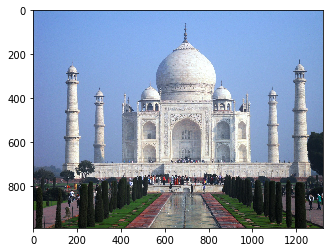

In [30]:
content_image = imageio.imread("images/Taj_mahal.jpg")
imshow(content_image)

We would want the generated image to have the same content as the content image. Hence we need to choose a few layer activations of image C and minimize the cost function below, so that they are similar to the activations of the same layers of the blank image G.


To achieve that we define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer we have chosen, and appear in a normalization term in the cost. $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. To make computations convenient, we unroll these 3D volumes into a 2D matrix making the new image dimensions as ($n_H *n_W$, $n_C$)


In [4]:

def content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that we compute using the equation above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape( (tf.transpose(a_C, perm = [3,2,1,0])), [n_C, n_H* n_W, 1] )
    a_G_unrolled = tf.reshape( (tf.transpose(a_G, perm = [3,2,1,0])), [n_C, n_H* n_W, m] )
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/ (4 * n_H * n_W * n_C)) * ( tf.reduce_sum ( tf.square( tf.subtract(a_C_unrolled , a_G_unrolled))))
    
    return J_content

In [5]:
# Sanity check

tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

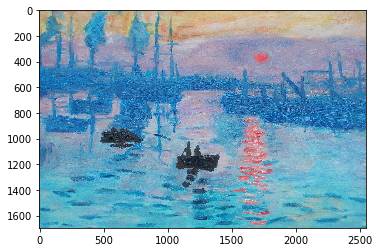

In [31]:
style_image = imageio.imread("images/mystyle.jpg")
imshow(style_image)

### 3.2.1 - Style matrix 

In order to compare the styles of the style image S and generated image G, we need to first compute their style matrices.
A style matrix $X$ of an image is the dot product of a hidden layer with itself. This gives information about how the activations( or filters) of a layer are correlated to each other. Each activation is responsible for a particular feature, say vertical texture and if the product of activation of this filter with another activation (responsible for horizontal texture) is large that means tere is a high probaility of both features to occur in the image together.

By capturing the prevalence of different types of features ($X_{ii}$), as well as how much different features occur together ($X_{ij}$), the Style matrix $X$ measures the style of an image. In algebra, style matrix is also known as Gram matrix.



In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    XA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    XA = tf.matmul(A, tf.transpose (A))  #, perm = [1, 0]))
    
    return XA

In [8]:
# sanity check

tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    XA = gram_matrix(A)
    
    print("XA = " + str(XA.eval()))
    

XA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


### 3.2.2 - Style cost

After generating the Style matrix, we would like to minimize the difference between the style matrix of image S and G, by minimizing the following Style cost function.


$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(X^{(S)}_{ij} - X^{(G)}_{ij})^2 $$

where $X^{(S)}$ and $X^{(G)}$ are respectively the Style matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [9]:
def layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape( (tf.transpose(a_S, perm = [3,2,1,0])), [n_C, n_H* n_W])    #, 1] )
    a_G = tf.reshape( (tf.transpose(a_G, perm = [3,2,1,0])), [n_C, n_H* n_W])    #, m] )

    # Computing gram_matrices for both images S and G (≈2 lines)
    XS = gram_matrix( a_S )
    XG = gram_matrix( a_G )

    # Computing the loss (≈1 line)
    J_style_layer = ( 1/ ( 4 * (n_C**2) * ((n_W * n_H)**2 ))) * ( tf.reduce_sum ( tf.square( tf.subtract(XS , XG ))))
    
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190277


### 3.2.3 Style Weights

Let's now select the activation layers from images S and C that we need to match with image G, so that G represents a good amalgame of the images S and C.


In [11]:
## layers and their weights lambdas

STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

Finally, we combine both cost functions into the function below and minimize it:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

$\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.


In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style 
    
    return J

In [15]:
# Sanity check

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [16]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()



Let's load, reshape, and normalize our "content" image (the Taj Mahal picture):

In [19]:
from nst_utils import *
import cv2

In [20]:
tj = imageio.imread("images/Taj_Mahal.jpg")
dim = (400,300)
tj1 = cv2.resize(tj, dim, interpolation = cv2.INTER_AREA)
content_image = tj1
content_image = reshape_and_normalize_image(content_image)

Let's load, reshape and normalize our "style" image (Impressionist painting):

In [21]:
my = imageio.imread("images/mystyle.jpg")
dim1 = (400,300)
my1 = cv2.resize(my, dim1, interpolation = cv2.INTER_AREA)
style_image = my1
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 300, 400, 3)


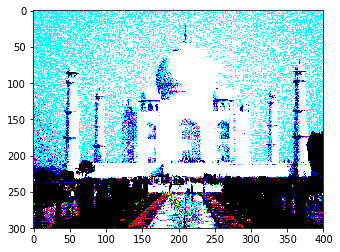

In [22]:
# Initialize G as a noise image from content image

generated_image = generate_noise_image(content_image)
print(generated_image.shape)
imshow(generated_image[0])

In [23]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [24]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = content_cost(a_C, a_G)

In [25]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [26]:
J = total_cost(J_content, J_style, alpha = 20, beta = 40)


You'd previously learned how to set up the Adam optimizer in TensorFlow. Lets do that here, using a learning rate of 2.0.  [See reference](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [27]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2)

# define train_step (1 line)
train_step = optimizer.minimize(J)

 Now we will feed the initial noise image as G to the VGG model, minimize the total loss defined above and generate an artistic image.

In [28]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run( tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run( model['input'].assign( input_image ))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Now let's run our model with the initial noise imag as G to generate an artistic image.

In [29]:
new1 = model_nn(sess, generated_image)

Iteration 0 :
total cost = 5332056600.0
content cost = 10864.846
style cost = 133295990.0
Iteration 20 :
total cost = 625986400.0
content cost = 17222.592
style cost = 15641050.0
Iteration 40 :
total cost = 227495040.0
content cost = 17343.305
style cost = 5678704.5
Iteration 60 :
total cost = 146203340.0
content cost = 17333.945
style cost = 3646417.0
Iteration 80 :
total cost = 108958850.0
content cost = 17336.812
style cost = 2715302.8
Iteration 100 :
total cost = 85474580.0
content cost = 17420.635
style cost = 2128154.0
Iteration 120 :
total cost = 68459170.0
content cost = 17561.277
style cost = 1702698.6
Iteration 140 :
total cost = 55520404.0
content cost = 17710.062
style cost = 1379155.1
Iteration 160 :
total cost = 45366360.0
content cost = 17847.033
style cost = 1125235.5
Iteration 180 :
total cost = 37311250.0
content cost = 17992.244
style cost = 923785.1


The results are quite pleasing:

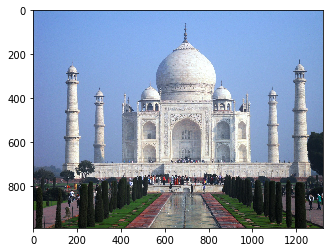

In [43]:
imshow(content_image)

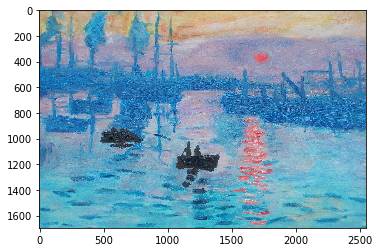

In [41]:
imshow(style_image)

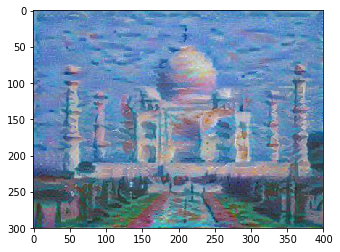

In [36]:
generated_image = imageio.imread('output/generated_image.jpg')
imshow(generated_image)

We can get even better looking results if we run the optimization algorithm for more iterations and with a smalled learning rate or using different weight for the hidden layers (perhaps more weightage for the deeper layers).

## Another example

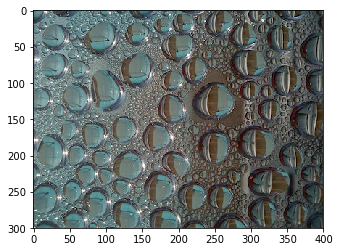

In [39]:
style2 = imageio.imread("images/mystyle2.jpg")
imshow(style2)

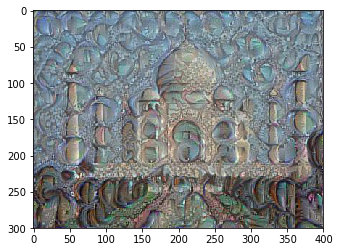

In [40]:
generated_image = imageio.imread('output/generated_image.jpg')
imshow(generated_image)

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 

- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)

- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
